In [12]:
import string
import regex as re
import pandas as pd
from sklearn.utils import resample
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemover, ArrayDictionary

In [40]:
reviews = pd.read_csv("dataset/tokocrypto_reviews.csv")
reviews = reviews.drop(columns=["reviewId", "userName"])
reviews = reviews.drop_duplicates()
reviews = reviews.dropna()

In [41]:
def returnSentiment(score):
    if (score >= 4):
        return "positive"
    elif (score <= 3):
        return "negative"

In [42]:
reviews["sentiment"] = reviews["score"].apply(returnSentiment)

In [43]:
reviews

,content,score,sentiment
0,Kecewa karena terlalu banyak potongan pajak: 1...,1,negative
1,"Scam? GA waktu login ulang berhasil, tapi pada...",1,negative
2,Ribet. Withdraw dalam waktu 60 detik harus mem...,1,negative
3,"Exchanger konyol, udah reset GA, giliran mau d...",1,negative
4,"Pada saat deposit, akun saya sedang login. Nam...",1,negative
...,...,...,...
4995,Aplikasi yang sangat bagus.Keamanan transaksi ...,5,positive
4996,"sy lebih suka trading disini, fitur2nya lebih ...",5,positive
4997,Aplikasi nya mudah banget dipelajari buat pemu...,5,positive
4998,Baru pertama main trading. Kirain susah ternya...,5,positive


Text Preprocessing

In [45]:
def remove_emojis(text):
    return str(text.encode('ascii', 'ignore'))

def remove_punctuation(text):
    # Make a regular expression that matches all punctuation
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    # Use the regex
    return regex.sub(' ', text)

# stopwords removal
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
def remove_stopwords_sastrawi(text):
    return stopword.remove(text)

# stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stem_words(text):
    return stemmer.stem(text)

# normalisasi kata tidak baku
slang_dict = pd.read_csv('dataset/normalization.csv', encoding='latin-1', header=None)
slang_dict = slang_dict.rename(columns={0: 'original',1: 'replacement'})
slang_dict_map = dict(zip(slang_dict['original'], slang_dict['replacement']))
def normalize_slang(text):
    return ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in text.split(' ')])

def preprocess(text):
    text1 = text.lower()   # case folding
    text4 = remove_emojis(text1)
    text5 = re.sub(r"\d+", "", text4)   # remove numbers
    text6 = text5.replace('\\n',' ')    # hapus karakter '\n'
    text7 = remove_punctuation(text6)
    text8 = normalize_slang(text7)
    text9 = stem_words(text8)
    text10 = remove_stopwords_sastrawi(text9)
    text11 = text10.replace("xf", " ")
    result = text11.strip()   # remove whitespace
    return result

reviews["preprocessed"] = reviews['content'].apply(preprocess)

In [46]:
reviews.head()

,content,score,sentiment,preprocessed
0,Kecewa karena terlalu banyak potongan pajak: 1...,1,negative,b kecewa terlalu banyak potong pajak waktu bel...
1,"Scam? GA waktu login ulang berhasil, tapi pada...",1,negative,b scam waktu login ulang hasil pada wd dadak g...
2,Ribet. Withdraw dalam waktu 60 detik harus mem...,1,negative,b ribet withdraw waktu detik masuk kode verifi...
3,"Exchanger konyol, udah reset GA, giliran mau d...",1,negative,b exchanger konyol reset gilir mau re connect ...
4,"Pada saat deposit, akun saya sedang login. Nam...",1,negative,b saat deposit akun sedang login telah deposit...


In [23]:
reviews.sentiment.value_counts()

sentiment
negative    3000
positive    1999
Name: count, dtype: int64

In [24]:
# Split data menjadi dua DataFrame berdasarkan sentiment
positive_reviews = reviews[reviews['sentiment'] == 'positive']
negative_reviews = reviews[reviews['sentiment'] == 'negative']

# Lakukan undersampling pada data negative agar jumlahnya menjadi 1999
undersampled_negative = resample(negative_reviews, replace=False, n_samples=1999, random_state=42)

# Gabungkan data positive dengan data negative yang sudah di-undersample
undersampled_reviews = pd.concat([positive_reviews, undersampled_negative])

# Tampilkan informasi setelah undersampling
print(undersampled_reviews['sentiment'].value_counts())

sentiment
positive    1999
negative    1999
Name: count, dtype: int64


In [26]:
undersampled_reviews.head()

,content,score,sentiment,preprocessed
3000,"Tolong dong min tambahkan pilihan menu SL/TP, ...",4,positive,b dong min tambah pilih menu sl karena trader ...
3001,kalau bisa coin yang ada harus fash update bia...,4,positive,b kalau coin fash baru biar tinggal exchange j...
3002,Sejauh ini fiturnya oke dan fee nya juga kompe...,4,positive,b jauh fiturnya oke fee nya kompetitif tolong ...
3003,"Tolong chart dibuat seperti binance, ada hitun...",4,positive,b chart buat binance hitung mundur waktu lain
3004,"Alamat wallet saya kok failed ini min,, Coba s...",4,positive,b alamat wallet kok failed min coba setor apli...


In [27]:
undersampled_reviews.to_csv('undersampled_reviews.csv', index=False)

358457


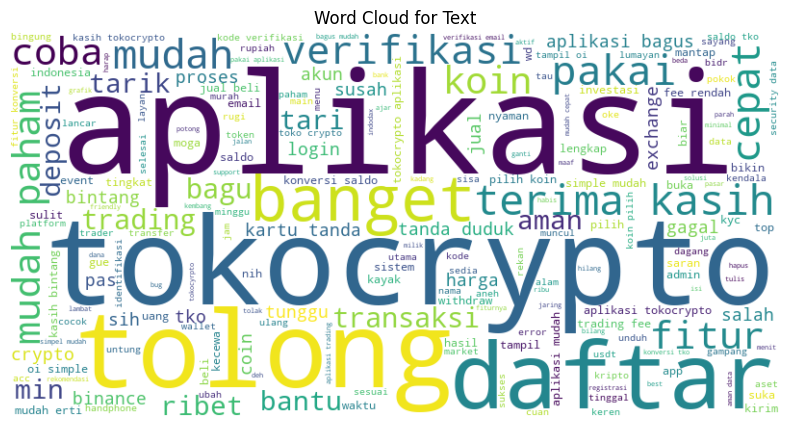

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all tweets into a single string
text = ' '.join(df['preprocessed'])
print(len(text)) #banyak karakter
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text')
plt.show()

#Feature Engineering

In [11]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True